In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM echo_features_mx
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,mech_vent,fl_day1_input_ml,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml
0,59654,245920,156140,70150,30260 days 15:18:03,M,66.0,263.0,42.444674,BLACK/AFRICAN AMERICAN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59659,217810,188268,82208,22331 days 14:54:57,F,59.0,136.0,27.465671,WHITE,...,1,2314.699969,17.0,2297.699969,250.000000,90.0,160.000000,NaN,NaN,NaN
2,59662,282885,100195,2489,24131 days 01:52:41,M,65.0,146.0,24.293018,UNKNOWN/NOT SPECIFIED,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59671,271833,130443,2961,30992 days 18:16:15,F,61.0,106.0,20.026337,WHITE,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59862,230661,116471,26601,-104003 days +15:46:42.290448,F,60.0,170.0,33.197222,WHITE,...,1,270.750000,363.0,-92.250000,75.583333,2890.0,-2814.416667,NaN,NaN,NaN


In [5]:
ef.columns.tolist()

['row_id',
 'icustay_id',
 'hadm_id',
 'subject_id',
 'age_at_intime',
 'gender',
 'height',
 'weight',
 'bmi',
 'ethnicity',
 'insurance',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascular',
 'ex_hypertension',
 'ex_paralysis',
 'ex_other_neurological',
 'ex_chronic_pulmonary',
 'ex_diabetes_uncomplicated',
 'ex_diabetes_complicated',
 'ex_hypothyroidism',
 'ex_renal_failure',
 'ex_liver_disease',
 'ex_peptic_ulcer',
 'ex_aids',
 'ex_lymphoma',
 'ex_metastatic_cancer',
 'ex_solid_tumor',
 'ex_rheumatoid_arthritis',
 'ex_coagulopathy',
 'ex_obesity',
 'ex_weight_loss',
 'ex_fluid_electrolyte',
 'ex_blood_loss_anemia',
 'ex_deficiency_anemias',
 'ex_alcohol_abuse',
 'ex_drug_abuse',
 'ex_psychoses',
 'ex_depression',
 'apsiii',
 'apsiii_prob',
 'apsiii_creatinine_score',
 'admittime',
 'dischtime',
 'intime',
 'outtime',
 'dod',
 'survived_icustay',
 'survived_hadm',
 'ed_chartdate',
 'ed_charttime',

In [38]:
## apply the data filters
filt = ef.ps_vaso & (~ef.diag_xc | ef.ex_congestive_heart_failure)

In [39]:
ef = ef.loc[filt]

In [40]:
len(ef)

5071

-4.0 3219.0
109
850
count    2319.000000
mean      274.118586
std       540.523299
min        -4.000000
25%         0.000000
50%        12.000000
75%       253.500000
max      3219.000000
dtype: float64


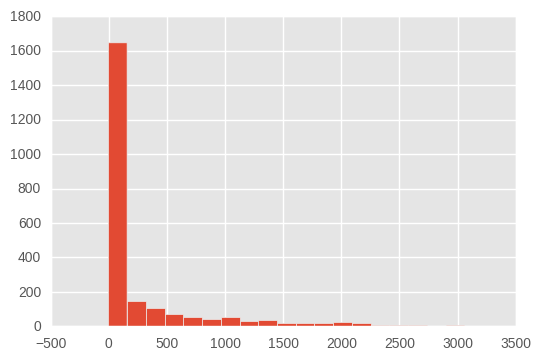

In [41]:
plot_data = ef.ea_days_after_discharge_death.values
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)
print(plot_data.min(), plot_data.max())
print(np.sum(plot_data < 0)) # only 324 out of 10k died before discharge???
print(np.sum(plot_data == 0)) # 2512 died at 0 minutes after discharge???
print(pd.Series(plot_data).describe())

In [42]:
day30_mortality = ef.ea_days_after_discharge_death <= 30

In [43]:
day30_mortality.value_counts()

False    3811
True     1260
Name: ea_days_after_discharge_death, dtype: int64

In [44]:
ef['day30_mortality'] = day30_mortality

In [45]:
ef.groupby(['day30_mortality', 'mech_vent']).size().unstack()

mech_vent,0,1
day30_mortality,,
False,2249,1562
True,403,857


In [46]:
ef.groupby(['day30_mortality', 'noninv_vent']).size().unstack()

noninv_vent,0,1
day30_mortality,,
False,446,3365
True,135,1125


In [47]:
%%bash
cat ../resources/lv_systolic.txt

====-1
Hyperdynamic LVEF >75%
Hyperdynamic LVEF
Left ventricular systolic function is hyperdynamic (EF>75%)
Hyperdynamic left ventricular systolic function
Hyperdynamic LVEF (>75%)
====0
Overall normal LVEF (>55%)
Normal LV wall thickness, cavity size and regional/global systolic function (LVEF >55%)
Low normal LVEF
Normal LV wall thickness, cavity size, and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and regional/global systolic function (LVEF>55%)
Overall left ventricular systolic function is normal (LVEF>55%)
Normal LV wall thickness, cavity size, and global systolic function (LVEF>55%)
Left ventricular wall thickness, cavity size, and systolic function are normal (LVEF>55%)
Mild symmetric LVH with normal cavity size and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and global systolic function (LVEF>55%)
Overall left ventricular systolic function is low normal (LVEF 50-55%)
There is mild symmetric left ventricular hypertrophy wi

In [48]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,19,143,1984,318,151,209
True,15,109,546,114,73,192


In [49]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table /= table.sum(axis=0)
table ## severely depressed and hyperdynamic have increased likelihood of death

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.558824,0.56746,0.78419,0.736111,0.674107,0.521197
True,0.441176,0.43254,0.21581,0.263889,0.325893,0.478803


In [51]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,2389,1422
True,360,900


In [50]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table /= table.sum(axis=0)
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,0.869043,0.612403
True,0.130957,0.387597


In [52]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    #table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,10,84,1500,208,60,13
True,6,59,209,27,10,8


Congestive heart failure = 1


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,9,59,484,110,91,196
True,9,50,337,87,63,184


In [53]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.625,0.587413,0.877706,0.885106,0.857143,0.619048
True,0.375,0.412587,0.122294,0.114894,0.142857,0.380952


Congestive heart failure = 1


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.5,0.541284,0.589525,0.558376,0.590909,0.515789
True,0.5,0.458716,0.410475,0.441624,0.409091,0.484211


count     4314.000000
mean      -585.328699
std       2343.195018
min     -52699.250000
25%      -1796.816303
50%       -790.100001
75%        335.375095
max      19110.315069
dtype: float64


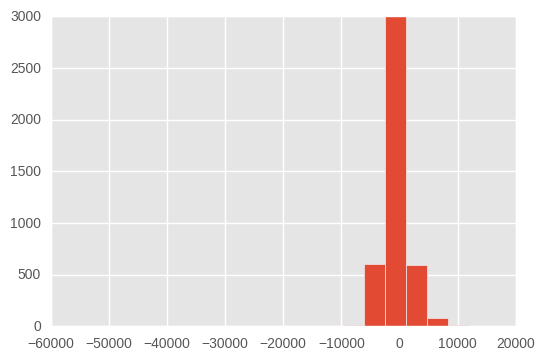

In [54]:
plot_data = ef.fl_day1_balance_ml.values
plot_data = plot_data[~np.isnan(plot_data)]
print(pd.Series(plot_data).describe())
#someone lost 137 litres ?!?!?!?!?
#someone was given 27 litres?
_ = plt.hist(plot_data, bins=20)

count    4285.000000
mean     -595.338284
std      2003.154984
min     -6779.166667
25%     -1791.975000
50%      -794.000000
75%       312.137500
max      7847.873574
dtype: float64


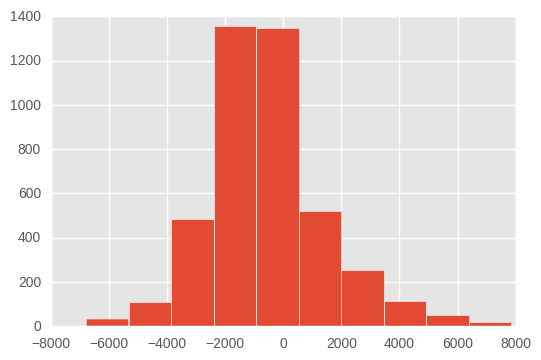

In [55]:
plot_data = ef.fl_day1_balance_ml.values.copy()
plot_data[plot_data < -7000] = np.nan
# should also remove upper bound on fluid, 8 litres max
plot_data[plot_data > 8000] = np.nan
plot_data = plot_data[~np.isnan(plot_data)]
print(pd.Series(plot_data).describe())
_ = plt.hist(plot_data)

 0.0     2530
 1.0      432
 3.0      401
-1.0      252
 2.0      224
-50.0      34
Name: ea_lv_systolic, dtype: int64

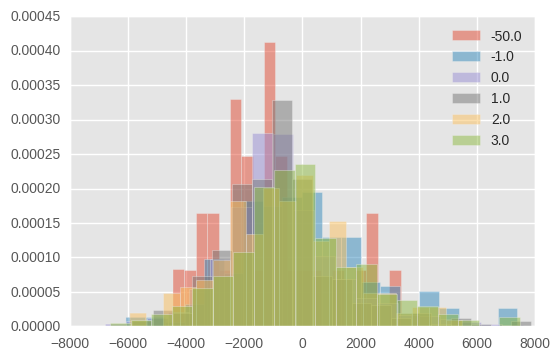

In [56]:
## if we group by echo lv systolic, what do the fluid distributions look like?
display(ef.ea_lv_systolic.value_counts())
for name,group in ef.groupby('ea_lv_systolic'):
    fluid = group.fl_day1_balance_ml.values.copy()
    fluid[fluid < -7000] = np.nan
    fluid[fluid > 8000] = np.nan
    fluid = fluid[~np.isnan(fluid)]
    plt.hist(fluid, alpha=0.5, label=str(name), normed=True, bins=20)
plt.legend(loc='best')

In [57]:
means = ef.groupby('ea_lv_systolic').mean()
stddevs = ef.groupby('ea_lv_systolic').std()
display(means)
display(stddevs)

,row_id,icustay_id,hadm_id,subject_id,height,weight,bmi,ex_congestive_heart_failure,ex_cardiac_aarrhythmias,ex_valvular_disease,...,fl_day1_input_ml,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,day30_mortality
ea_lv_systolic,,,,,,,,,,,,,,,,,,,,,
-50.0,79482.147059,246891.117647,146635.470588,24705.323529,66.478261,190.925926,30.352684,0.529412,0.411765,0.147059,...,965.949233,2151.000000,-1185.050767,775.660887,1887.958333,-1112.297446,963.296032,1972.545455,-1009.249423,0.441176
-1.0,84806.269841,252601.123016,151661.734127,41994.682540,66.194175,184.995633,29.176638,0.432540,0.289683,0.083333,...,2020.487659,2013.900433,6.587226,1451.620694,2219.778894,-768.158200,1444.254074,2345.887640,-901.633566,0.432540
0.0,83664.030830,250328.995257,149987.989328,41648.521344,66.591446,188.312565,29.669839,0.324506,0.248221,0.081028,...,1399.898419,2092.309892,-692.411472,1198.686863,2297.582158,-1098.895295,1150.159493,2397.396084,-1247.236591,0.215810
1.0,83425.127315,249026.020833,149586.423611,38395.120370,66.625874,187.396774,29.835414,0.456019,0.310185,0.111111,...,1271.545273,2162.168831,-890.623559,922.895154,2166.800813,-1243.905660,794.678202,2275.930108,-1481.251906,0.263889
2.0,83534.732143,251930.334821,150933.741071,34203.196429,66.844311,180.929348,28.333614,0.687500,0.379464,0.241071,...,1565.250051,2070.372973,-505.122922,1215.632718,2109.164384,-893.531665,1138.993856,2268.515200,-1129.521344,0.325893
3.0,81433.493766,250287.468828,151353.740648,33354.708229,67.104294,184.666667,29.058179,0.947631,0.536160,0.221945,...,1745.766169,1793.905970,-48.139801,1297.631416,2067.384106,-769.752690,1089.459455,2429.361624,-1339.902169,0.478803


,row_id,icustay_id,hadm_id,subject_id,height,weight,bmi,ex_congestive_heart_failure,ex_cardiac_aarrhythmias,ex_valvular_disease,...,fl_day1_input_ml,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,day30_mortality
ea_lv_systolic,,,,,,,,,,,,,,,,,,,,,
-50.0,10477.262334,27329.672850,31794.786707,24017.969192,3.043168,57.281979,8.551084,0.506640,0.499554,0.359491,...,1255.208241,1304.074333,1912.848508,741.813166,1082.184485,1373.909411,1226.186658,1056.312982,1873.154420,0.503995
-1.0,12140.705066,27759.401812,28724.614627,30731.324135,4.591739,57.753674,8.320793,0.496414,0.454518,0.276935,...,1959.201779,1548.181748,2492.017847,1357.134663,1595.459321,2103.956619,1573.809054,1641.935033,2233.309936,0.496414
0.0,12430.420593,28585.087906,29090.489329,29059.301074,4.372788,61.823497,8.885234,0.468283,0.432066,0.272932,...,1658.657305,1353.970789,2041.580707,1293.470998,1768.130834,2175.653456,1304.263745,1648.016282,2096.267528,0.411465
1.0,12717.419067,28909.106290,29332.111522,28580.897759,4.228130,56.851256,9.177863,0.498639,0.463106,0.314634,...,1769.995448,2915.279805,3365.389077,1162.479443,1826.813989,2221.374511,904.832508,1546.274774,1867.771497,0.441251
2.0,12745.331174,28949.556814,28740.421824,28596.915656,3.883819,60.428166,8.964148,0.464551,0.486340,0.428692,...,1866.442937,1595.503494,2305.963713,1290.793768,1490.215027,1897.939955,1183.590336,1529.354394,1992.605557,0.469757
3.0,12970.772161,29682.033017,28639.414115,27611.142201,4.840360,60.408094,9.901460,0.223048,0.499314,0.416074,...,2228.855947,1424.292279,2686.785891,1497.221383,1756.876318,2411.119588,1187.306430,1707.767968,2192.377198,0.500175


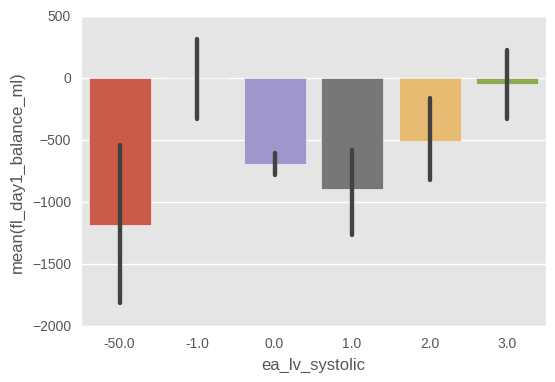

In [58]:
sns.barplot(x='ea_lv_systolic', y='fl_day1_balance_ml', data=ef)

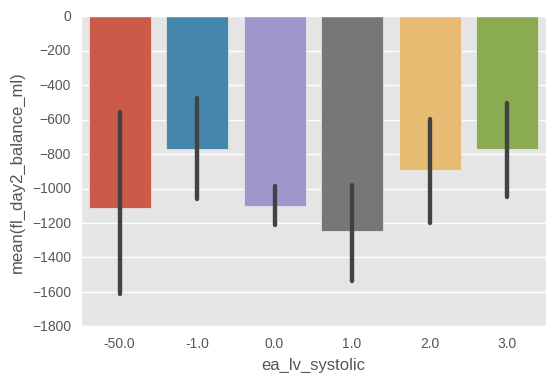

In [59]:
sns.barplot(x='ea_lv_systolic', y='fl_day2_balance_ml', data=ef)

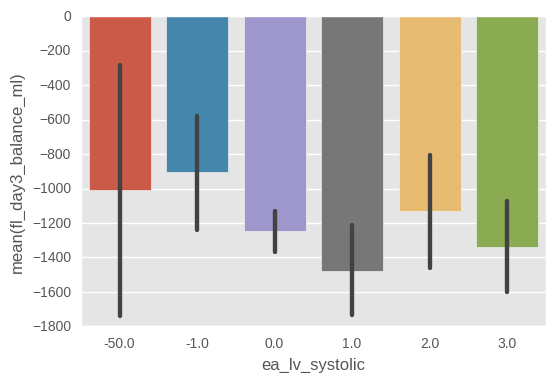

In [60]:
sns.barplot(x='ea_lv_systolic', y='fl_day3_balance_ml', data=ef)

Congestive heart failure = 0


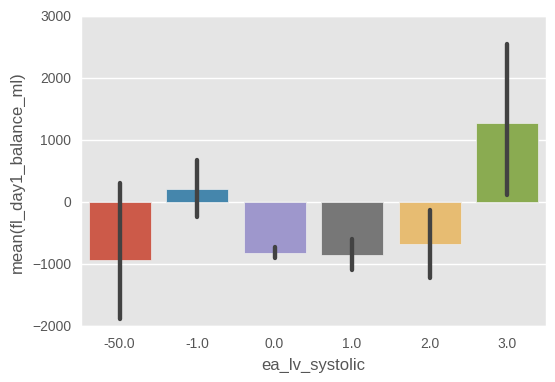

Congestive heart failure = 1


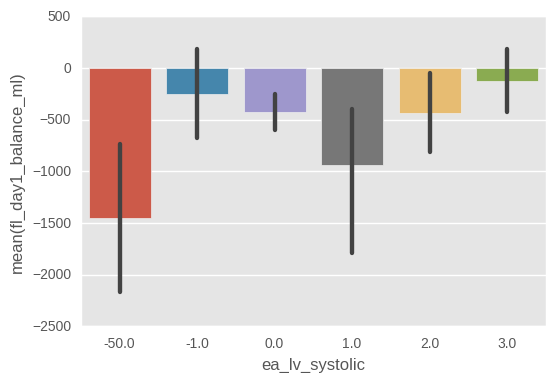

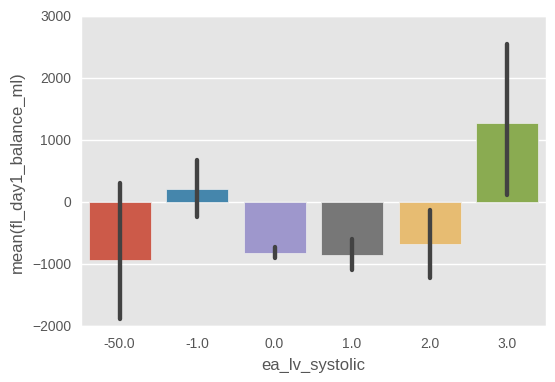

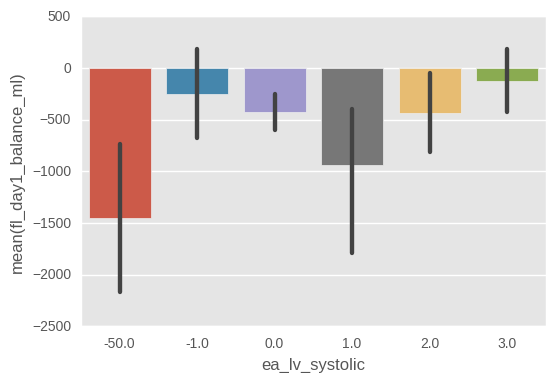

In [61]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    print('Congestive heart failure =', name)
    f = plt.figure()
    sns.barplot(x='ea_lv_systolic', y='fl_day1_balance_ml', data=group)
    display(f)
pass

Congestive heart failure = (0, -50.0)
AUC: 0.666666666667 , correlation: 0.37151970339
Congestive heart failure = (0, -1.0)
AUC: 0.591071428571 , correlation: 0.145191826609
Congestive heart failure = (0, 0.0)
AUC: 0.662494750987 , correlation: 0.195815863377
Congestive heart failure = (0, 1.0)
AUC: 0.691093017518 , correlation: 0.152609513333
Congestive heart failure = (0, 2.0)
AUC: 0.773291925466 , correlation: 0.362060467399
Congestive heart failure = (0, 3.0)
AUC: 0.402777777778 , correlation: -0.162768929263
Congestive heart failure = (1, -50.0)
AUC: 0.571428571429 , correlation: 0.113626125333
Congestive heart failure = (1, -1.0)
AUC: 0.54269005848 , correlation: 0.0414310483921
Congestive heart failure = (1, 0.0)
AUC: 0.642515962572 , correlation: 0.207464399102
Congestive heart failure = (1, 1.0)
AUC: 0.65 , correlation: 0.172298516622
Congestive heart failure = (1, 2.0)
AUC: 0.609268292683 , correlation: 0.181950971939
Congestive heart failure = (1, 3.0)
AUC: 0.67673516712 , c

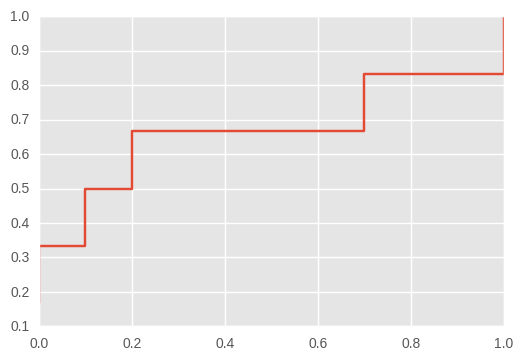

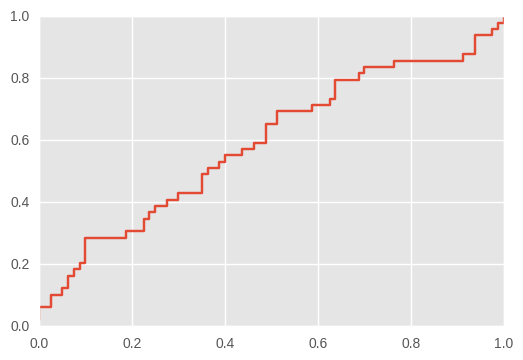

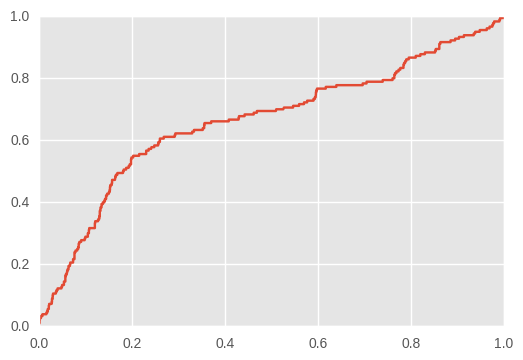

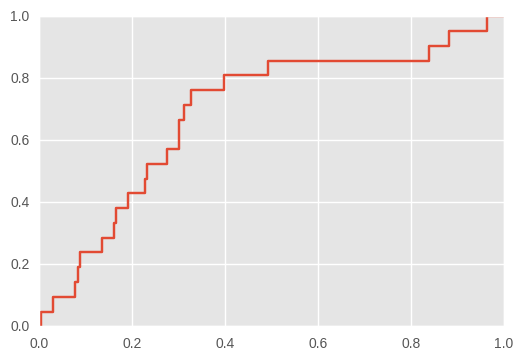

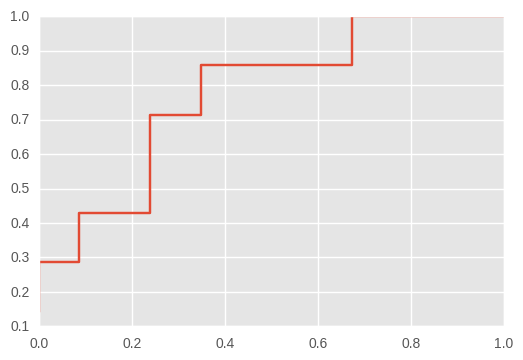

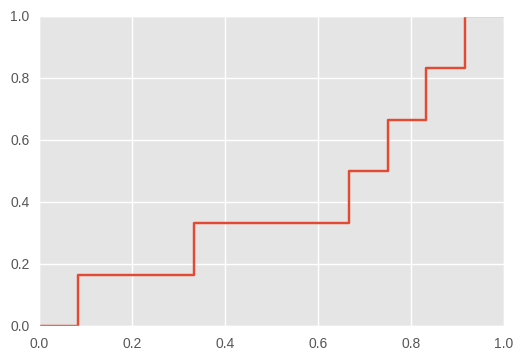

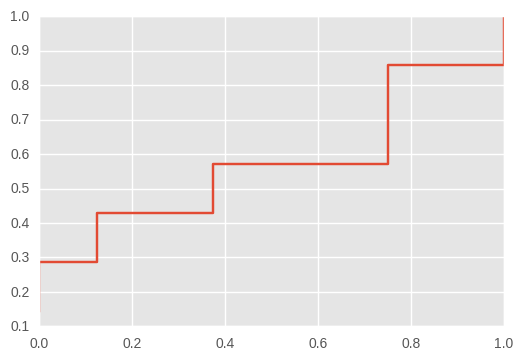

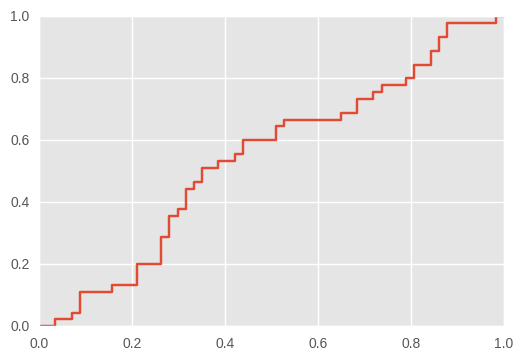

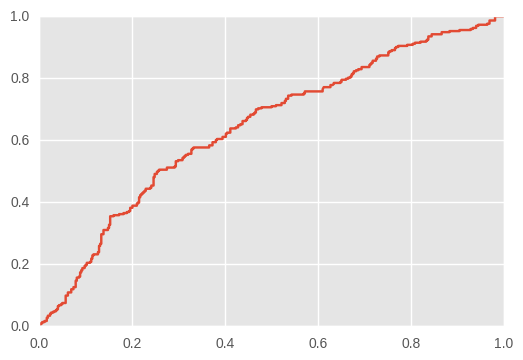

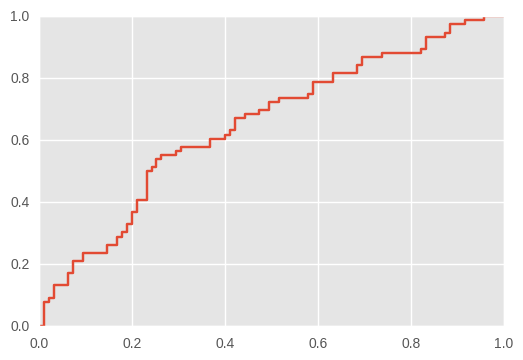

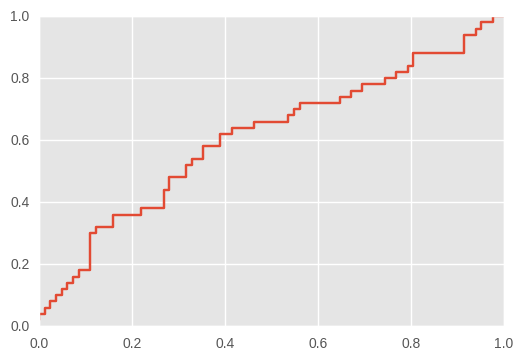

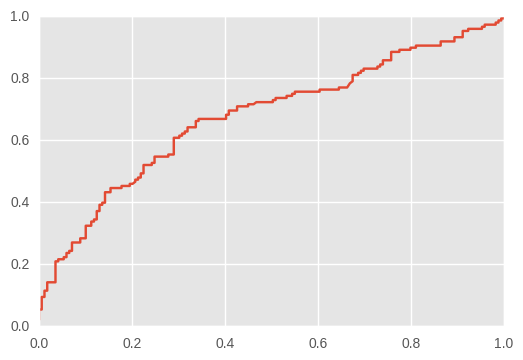

In [62]:
from sklearn.metrics import roc_curve, auc
## hypothesis: people with fluid do better in -1 than 3
for name,group in ef.groupby(['ex_congestive_heart_failure', 'ea_lv_systolic']):
    print('Congestive heart failure =', name)
    y_true = group.day30_mortality.values.copy()
    y_pred = group.fl_day1_balance_ml.values.copy()
    I = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[I]
    y_pred = y_pred[I]
    fpr, tpr, _ = roc_curve(y_true[...,np.newaxis], y_pred[...,np.newaxis])
    v = auc(fpr, tpr)
    c = np.corrcoef(y_pred, y_true)[0,1]
    print('AUC:', v, ', correlation:', c)
    f = plt.figure()
    plt.plot(fpr, tpr)